In [2]:
import numpy as np


def distance(p1, p2):
    """Returns the distance between two points p1 and p2"""
    return np.sqrt(np.sum((p1 - p2)**2))

In [3]:
import scipy.stats as ss
import random


def majority_vote(votes):
    """Returns majority vote and its count in a list of votes"""
    vote_counts = {}
    for vote in votes:
        if vote in vote_counts:
            vote_counts[vote] += 1
        else:
            vote_counts[vote] = 1
    winners = []
    max_counts = max(vote_counts.values())
    for vote, count in vote_counts.items():
        if count == max_counts:
            winners.append(vote)
    return random.choice(winners)


def majority_vote_short(votes):
    """Returns majority vote and its count in a list of votes"""
    mode, count = ss.mstats.mode(votes)
    return mode, count

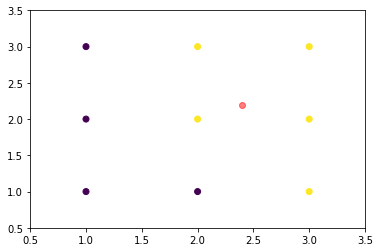

In [4]:
import matplotlib.pyplot as plt
# Point to find the distance from
point = np.array([2.4, 2.2])
# Toy data points
points = np.array([[1, 1], [1, 2], [1, 3], [2, 1], [2, 2], [2, 3], [3, 1],
                   [3, 2], [3, 3]])
# Labels of the correspoinding points
labels = np.array([*np.zeros((4, ), dtype=int), *np.ones((5, ), dtype=int)])

plt.scatter(points[:, 0], points[:, 1], c=labels)
plt.plot(point[0], point[1], "ro", alpha=0.5)
plt.xlim(0.5, 3.5)
plt.ylim(0.5, 3.5)
plt.show()

In [91]:
def knn_predict(point, points, labels, k = 5):
    """Returns the predicted label of the point"""
    distances = np.zeros(points.shape[0])
    for i in range(len(distances)):
        distances[i] = distance(point, points[i])
    ind = np.argsort(distances)
    return majority_vote(labels[ind][:k])

In [94]:
def synth_data(n=50):
    """Returns 2n bivariate random variates and labels """
    labels = np.concatenate((np.repeat(0, n), np.repeat(1, n)))
    points = np.concatenate(
        (ss.norm(0, 1).rvs((n, 2)), ss.norm(1, 1).rvs((n, 2))), axis=0)
    return points, labels

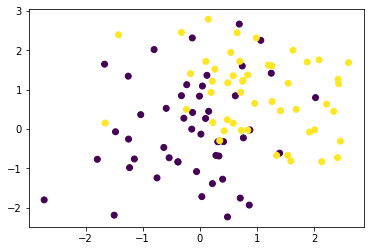

In [134]:
# Sample generator testing
points, labels = synth_data()
plt.scatter(points[:, 0], points[:, 1], c = labels)
plt.show()